In [1]:
from discriminator_model import Discriminator
from dataset import load_dataset
from Generator import Unet

/home/pankaj/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


cpu
torch.Size([1, 3, 256, 256])
torch.Size([1, 6, 128, 128])


In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt


In [3]:
device = "cpu"
print(device)
#"cuda" if torch.cuda.is_available() else 

cpu


In [4]:
disc = Discriminator(in_channels=3).to(device)
gen = Unet(in_channels=3, out_channels=3).to(device)
disc_opt = optim.Adam(disc.parameters(), lr = 2e-4, betas = (0.5, 0.999))
gen_opt = optim.Adam(gen.parameters(), lr = 2e-4, betas = (0.5, 0.999))

In [5]:
BCE = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

In [6]:
path = "./maps/train"
x_data = []
for img in os.listdir(path):
    img_path = os.path.join(path, img)
    x_data.append(img_path)
x_data = np.array(x_data)
train_dataset = load_dataset(x_data,batch_size=16)

In [7]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

/home/pankaj/.local/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [8]:
import torch.nn.functional as F
# New parameters
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 20
input_dim = 3
real_dim = 3
display_step = 200
batch_size = 4
lr = 0.0002
target_shape = 256
device = 'cuda'

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

import torchvision
dataset = torchvision.datasets.ImageFolder("maps", transform=transform)

In [11]:

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
# Feel free to change pretrained to False if you're training the model from scratch
pretrained = True
if pretrained:
    loaded_state = torch.load("pix2pix_15000.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

UnpicklingError: invalid load key, '<'.

In [10]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 2194
    Root location: maps
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [11]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: get_gen_loss
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        disc: the discriminator; takes images and the condition and
          returns real/fake prediction matrices
        real: the real images (e.g. maps) to be used to evaluate the reconstruction
        condition: the source images (e.g. satellite imagery) which are used to produce the real images
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the true labels and returns a adversarial 
                  loss (which you aim to minimize)
        recon_criterion: the reconstruction loss function; takes the generator 
                    outputs and the real images and returns a reconstructuion 
                    loss (which you aim to minimize)
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''
    # Steps: 1) Generate the fake images, based on the conditions.
    #        2) Evaluate the fake images and the condition with the discriminator.
    #        3) Calculate the adversarial and reconstruction losses.
    #        4) Add the two losses, weighting the reconstruction loss appropriately.
    #### START CODE HERE ####
    fake = gen(condition)
    disc_fake_hat = disc(fake, condition)
    gen_adv_loss = adv_criterion(disc_fake_hat, torch.ones_like(disc_fake_hat))
    gen_rec_loss = recon_criterion(real, fake)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss
    #### END CODE HERE ####
    return gen_loss

In [12]:
# UNIT TEST
def test_gen_reasonable(num_images=10):
    gen = torch.zeros_like
    disc = lambda x, y: torch.ones(len(x), 1)
    real = None
    condition = torch.ones(num_images, 3, 10, 10)
    adv_criterion = torch.mul
    recon_criterion = lambda x, y: torch.tensor(0)
    lambda_recon = 0
    assert get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon).sum() == num_images

    disc = lambda x, y: torch.zeros(len(x), 1)
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)).sum() == 0

    adv_criterion = lambda x, y: torch.tensor(0)
    recon_criterion = lambda x, y: torch.abs(x - y).max()
    real = torch.randn(num_images, 3, 10, 10)
    lambda_recon = 2
    gen = lambda x: real + 1
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon) - 2) < 1e-4

    adv_criterion = lambda x, y: (x + y).max() + x.max()
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon) - 3) < 1e-4
test_gen_reasonable()
print("Success!")

Success!


In [18]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

  0%|          | 0/549 [00:00<?, ?it/s]

Pretrained initial state


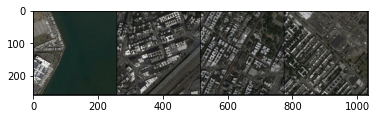

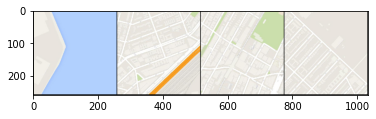

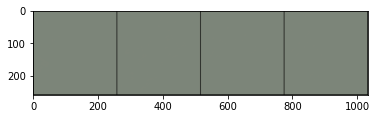

 36%|███▋      | 200/549 [1:26:00<2:44:50, 28.34s/it]

Epoch 0: Step 200: Generator (U-Net) loss: 76.78323616027836, Discriminator loss: 0.3632966766506434


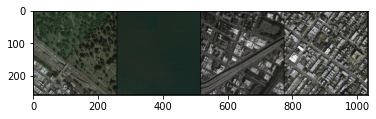

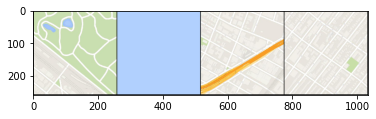

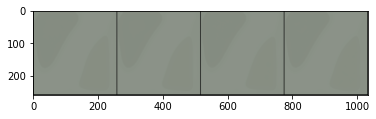

 73%|███████▎  | 400/549 [2:32:49<40:05, 16.15s/it]  

Epoch 0: Step 400: Generator (U-Net) loss: 62.0815107536316, Discriminator loss: 0.13519339554943133


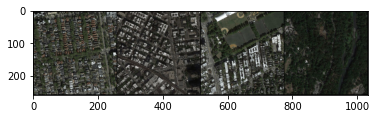

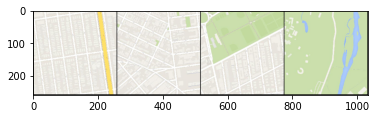

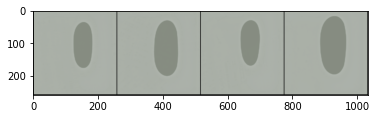

  4%|▍         | 22/549 [07:46<3:06:26, 21.23s/it]


KeyboardInterrupt: 

In [21]:
from skimage import color
import numpy as np

def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(dataloader):
            image_width = image.shape[3]
            condition = image[:, :, :, :image_width // 2]
            condition = nn.functional.interpolate(condition, size=target_shape)
            real = image[:, :, :, image_width // 2:]
            real = nn.functional.interpolate(real, size=target_shape)
            cur_batch_size = len(condition)
#             condition = condition.to(device)
#             real = real.to(device)

            ### Update discriminator ###
            disc_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake = gen(condition)
            disc_fake_hat = disc(fake.detach(), condition) # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(real, condition)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True) # Update gradients
            disc_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(real_dim, target_shape, target_shape))
                show_tensor_images(fake, size=(real_dim, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"pix2pix_{cur_step}.pth")
            cur_step += 1
train()